# Model Training Introduction

In this section, we embark on training machine learning models to classify Reddit posts. We've pre-processed my textual data and explored key patterns. Now, we're ready to apply machine learning algorithms to predict whether a new post belongs to r/movies or r/books based on the text content.


In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

## Load Data

In [17]:
%store -r data

In [18]:
data.head(2)

,text,sentiment,label
0,official discussion megathread monkey man firs...,0.100000,0
1,hi joshua caldwell directorproducer mending li...,0.302386,0


# Data Preparation

We prepare my data for modeling by splitting it into training and testing sets. This separation allows us to train my models on one subset of the data and then test their performance on unseen data to ensure that my models can generalize well.


## Split Data

In [19]:
X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

# Random Forest Classifier

We start with a Random Forest classifier, an ensemble learning method known for its robustness and accuracy. We create a pipeline with `TfidfVectorizer` to convert text data into a format that the algorithm can process, and we use `GridSearchCV` to find the best hyperparameters for my model.


## Random Forest

In [20]:
rand_forest_pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('rand_forest', RandomForestClassifier())
    ]
)

forest_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'rand_forest__n_estimators': [100, 200, 300],
    'rand_forest__max_depth': [10, 20, 30]

}

rand_forest_gs = GridSearchCV(
    estimator=rand_forest_pipe,
    param_grid=forest_param_grid,
    cv=5,
    n_jobs=-1
)

rand_forest_gs.fit(X_train, y_train)

print(f'Best Params: {rand_forest_gs.best_params_}')
print(f'Best Accuracy: {rand_forest_gs.best_score_}')
print(f'Test Accuracy: {rand_forest_gs.score(X_test, y_test)}')

Best Params: {'rand_forest__max_depth': 30, 'rand_forest__n_estimators': 300, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 3)}
Best Accuracy: 0.8040449134199135
Test Accuracy: 0.7759336099585062


### Rand Forest Confusion Matrix

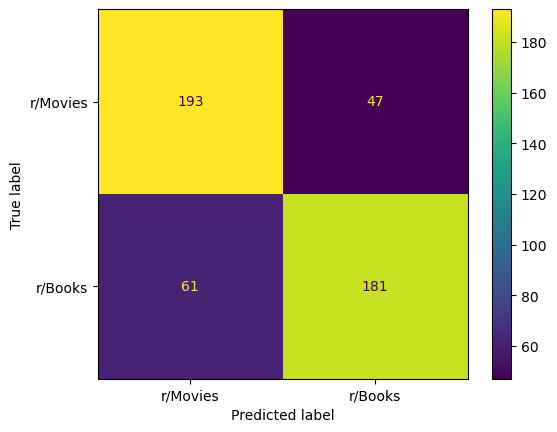

In [27]:
# Plot the confusion matrix
# Adjust Labels
forst_y_pred = rand_forest_gs.predict(X_test)
forest_cm = confusion_matrix(y_test, forst_y_pred)
forest_disp = ConfusionMatrixDisplay(confusion_matrix=forest_cm, display_labels=['r/Movies', 'r/Books'])
forest_disp.plot();


# Model Evaluation - Random Forest

After training the Random Forest classifier, we evaluate its performance by looking at accuracy and a confusion matrix, which gives us a detailed view of how well the model is predicting each class.


## Random Forest - Top 10 Features

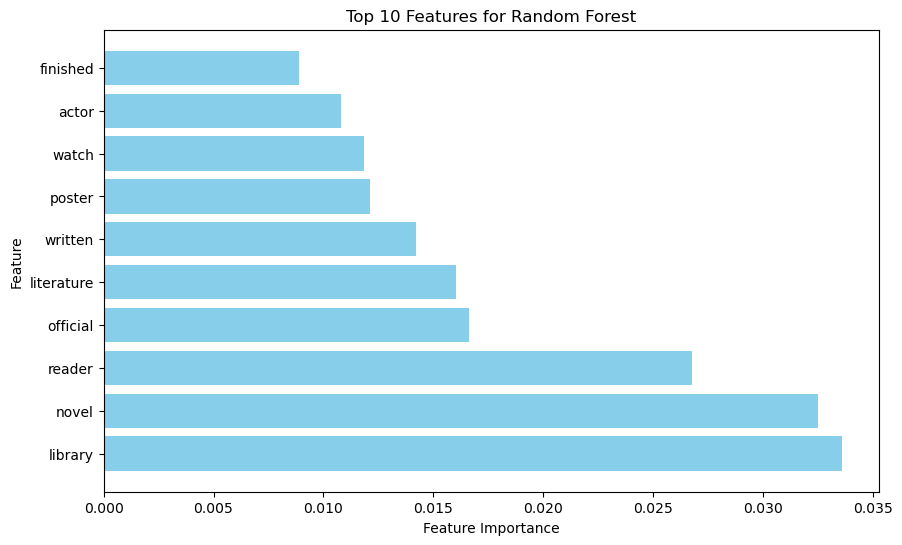

In [55]:
# Get the feature names
rand_forest_fea = rand_forest_gs.best_estimator_.named_steps['tfidf'].get_feature_names_out()

# Get the feature importances
rand_forest_imp = rand_forest_gs.best_estimator_.named_steps['rand_forest'].feature_importances_

# Combine the feature names and importances
rand_forest_features = list(zip(rand_forest_fea, rand_forest_imp))

# Sort the features by importance
rand_forest_features.sort(key=lambda x: x[1], reverse=True)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in rand_forest_features[:10]], [f[1] for f in rand_forest_features[:10]], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features for Random Forest')
plt.show()

# Feature Importance Analysis

Understanding which features are most informative in predicting the subreddit category can provide insights into the model's decision-making process. Here, we plot the top 10 features based on their importance as determined by the Random Forest classifier.


# Support Vector Classifier

Next, we train a Support Vector Classifier (SVC) with a linear kernel. Similar to the Random Forest model, we use `GridSearchCV` to tune hyperparameters. SVCs are particularly well-suited for high-dimensional spaces, which is typical for text classification problems.


## Support Vector Classifier (SVC)

In [49]:
svc_pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('svc', SVC(kernel='linear'))
    ]
)

svc_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'svc__C': [1, 10, 100],
    #'svc__kernel': ['linear', 'rbf']
}

svc_gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=svc_param_grid,
    cv=5,
    n_jobs=-1
)

svc_gs.fit(X_train, y_train)

print(f'Best Params: {svc_gs.best_params_}')
print(f'Best Accuracy: {svc_gs.best_score_}')
print(f'Test Accuracy: {svc_gs.score(X_test, y_test)}')

Best Params: {'svc__C': 1, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 3)}
Best Accuracy: 0.8762987012987011
Test Accuracy: 0.8858921161825726


### SVC Confusion Matrix

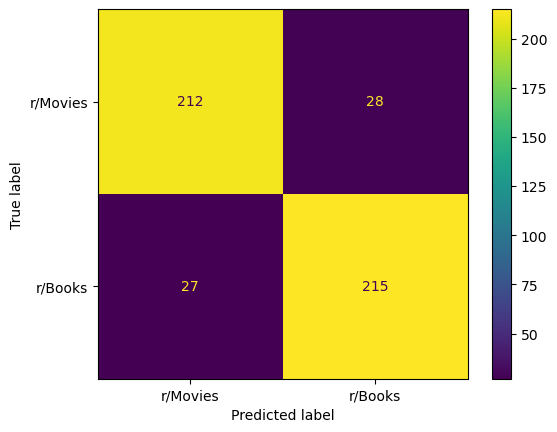

In [ ]:
svc_y_pred = svc_gs.predict(X_test)
svc_cm = confusion_matrix(y_test, svc_y_pred)
svc_disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=['r/Movies', 'r/Books'])
svc_disp.plot();

# Model Evaluation - SVC

I evaluate the performance of the SVC model using the same metrics as the Random Forest. The confusion matrix here provides an insight into how well the SVC model distinguishes between the two subreddits.


### SVC - Top 10 Features

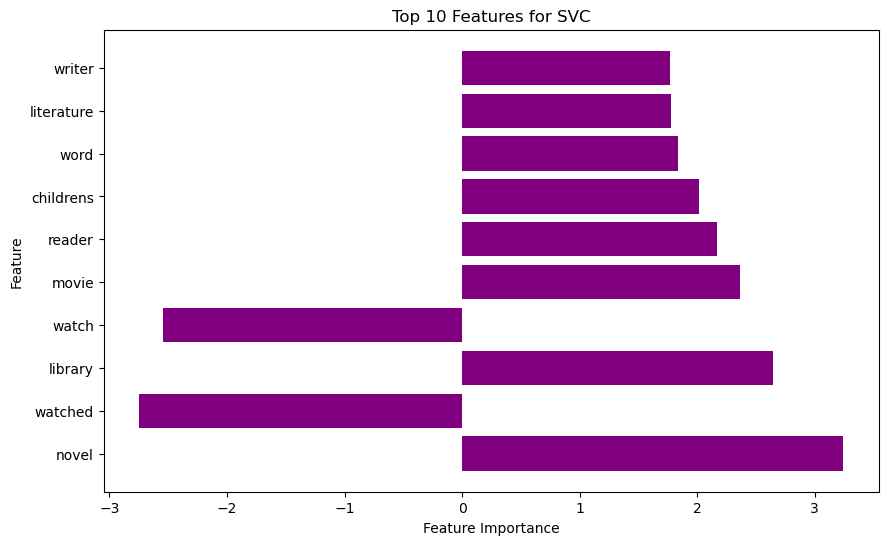

In [54]:
# Extracting feature names
svc_fea = svc_gs.best_estimator_.named_steps['tfidf'].get_feature_names_out()

# Extracting coefficients
svc_imp = svc_gs.best_estimator_.named_steps['svc'].coef_.toarray().flatten()

# Pairing features with their coefficients and sorting by absolute value of coefficients
svc_features = list(zip(svc_fea, svc_imp))
svc_features.sort(key=lambda x: abs(x[1]), reverse=True)  # Sorting by absolute value for more meaningful impact analysis

# Plotting
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in svc_features[:10]], [f[1] for f in svc_features[:10]], color='purple')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features for SVC')
plt.show()


# Coefficient Analysis for SVC

The coefficients from an SVC with a linear kernel can tell us about the relationship between each feature and the class labels. A positive coefficient indicates a feature that is indicative of r/movies, while a negative coefficient indicates a feature that is indicative of r/books. I examine the top features to understand which words are most influential in the classification decision.


# Conclusion of Classification

In this notebook, I have successfully developed and tuned two machine learning models to classify Reddit posts. The Random Forest and SVC models showed good performance, and their respective analyses of feature importance and coefficients provided deeper insights into the predictive patterns within the data. These models can now be utilized for automated classification of posts, supporting content curation and user engagement on Reddit.
